In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
from matplotlib import pyplot as plt
import rasterstats
from rasterio.plot import show
from rasterio.plot import show_hist

In [6]:
from rasterio.mask import mask
from shapely.geometry import mapping

In [7]:
training_sites = gpd.read_file(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg', layer = 'sitios_entrenamient_2021' )

In [8]:
training_sites.dtypes

class         object
geometry    geometry
dtype: object

<Axes: >

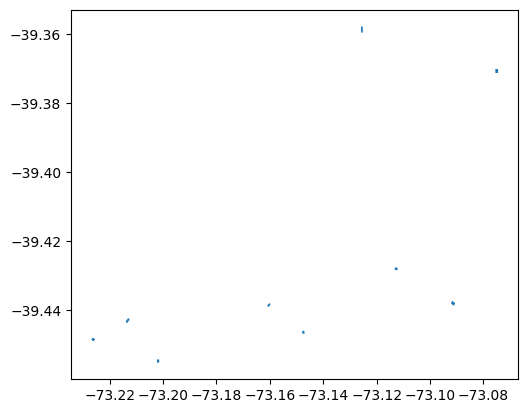

In [9]:
training_sites.plot()

1.- La documentación de Rasterio 

In [10]:
dataset = rasterio.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\2021\SR_B1_2021.tif')

In [11]:
composite = rasterio.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\2021\composite_2021_summer.tif')

In [12]:
composite.bounds

BoundingBox(left=-73.50734306893222, bottom=-39.699786340264495, right=-72.77377880792021, top=-39.3413585419008)

In [13]:
{i: dtype for i, dtype in zip(composite.indexes, composite.dtypes)}
{1: 'uint16'}

{1: 'uint16'}

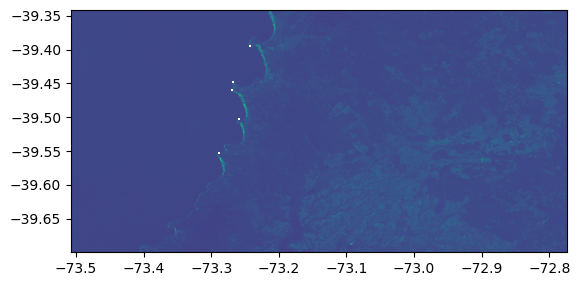

<Axes: >

In [14]:
show(composite)

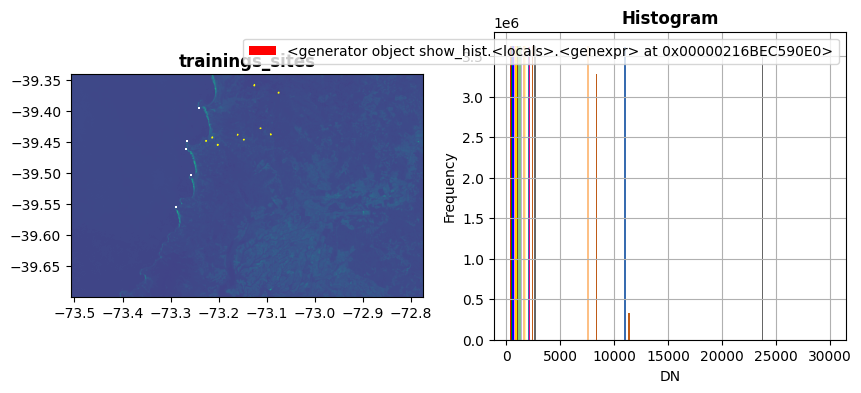

In [15]:
# Plotting the raster and shapefile together

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))
show(composite, ax = ax1, title = "trainings_sites")
training_sites.plot(ax = ax1, facecolor = 'None', edgecolor = 'yellow')
show_hist(composite, title = 'Histogram', ax = ax2)
plt.show()

In [16]:
type(composite) # This is a rasterio object

rasterio.io.DatasetReader

In [17]:
print(composite.shape)
print(composite.count)


(1330, 2722)
19


In [18]:
import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = composite.read([4,3,2])[:, 400:600, 1000:1400]

In [19]:
print(clipped_img.shape)

(3, 200, 400)


<Axes: >

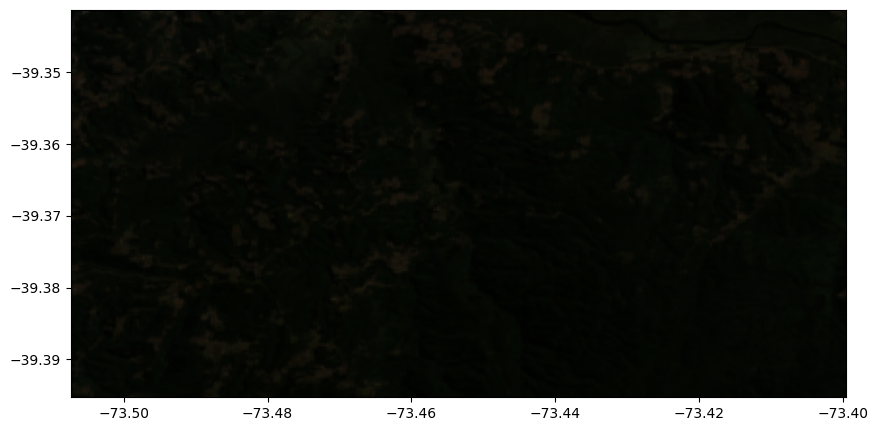

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=composite.transform) # add the transform arg to get it in lat long coo

In [21]:
composite.crs

CRS.from_epsg(4326)

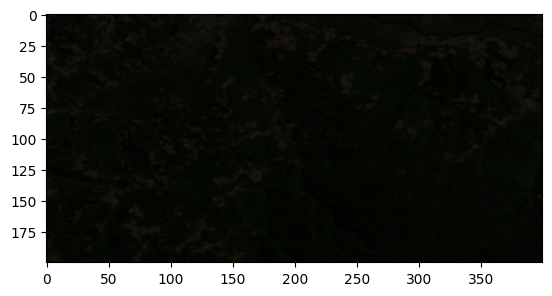

<Axes: >

In [22]:
show(clipped_img)

In [23]:
training_sites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
geoms = training_sites.geometry.values 

In [25]:
# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)


<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((-73.20228317899202 -39.45427231205459, -73.20224826902074 -39.45507524139381, -73.20150352296697 -39.45509851470799, -73.20143370302443 -39.45430722202587, -73.20228317899202 -39.45427231205459))


In [26]:
# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'list'>
[{'type': 'Polygon', 'coordinates': (((-73.20228317899202, -39.45427231205459), (-73.20224826902074, -39.45507524139381), (-73.20150352296697, -39.45509851470799), (-73.20143370302443, -39.45430722202587), (-73.20228317899202, -39.45427231205459)),)}]


In [27]:
out_image, out_transform = mask(composite, feature, crop=True)
out_image.shape

(19, 5, 5)

In [28]:
type(out_image)

numpy.ndarray

In [29]:
type(out_image) #### Esto habria que plotearlo con matplotlib

numpy.ndarray

In [30]:
out_image.shape

(19, 5, 5)

In [31]:
import numpy as np

In [32]:
X = np.array([], dtype=np.int8).reshape(0,19)
y = np.array([], dtype=np.string_)  ##### Revisar pero por alguna razón. 



In [33]:
y

array([], dtype='|S1')

In [34]:
# this generates a list of shapely geometries
geoms = training_sites.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((-73.20228317899202 -39.45427231205459, -73.20224826902074 -39.45507524139381, -73.20150352296697 -39.45509851470799, -73.20143370302443 -39.45430722202587, -73.20228317899202 -39.45427231205459))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((-73.20228317899202, -39.45427231205459), (-73.20224826902074, -39.45507524139381), (-73.20150352296697, -39.45509851470799), (-73.20143370302443, -39.45430722202587), (-73.20228317899202, -39.45427231205459)),)}]


In [ ]:
training_sites

In [ ]:
### Este es el paso critico para entender la estructura de lo que esta haciendo ###

with rasterio.open(composite) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array # esto hay que corregirlo porque en teoria estamos usando numeros
        y = np.append(y,[shapefile["class"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))        

In [ ]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

In [191]:
len(training_sites)

10

In [192]:
# Assign raster values to a numpy nd array
dataset_array = dataset.read(1)

In [193]:
dataset_array

array([[0.0070475 , 0.0055075 , 0.0055075 , ..., 0.00581   , 0.00449   ,
        0.00449   ],
       [0.0066625 , 0.0067175 , 0.0067175 , ..., 0.00273   , 0.002895  ,
        0.002895  ],
       [0.008395  , 0.008395  , 0.00625   , ..., 0.0056175 , 0.004985  ,
        0.004985  ],
       ...,
       [0.00598875, 0.004655  , 0.004655  , ..., 0.01275375, 0.00988   ,
        0.008835  ],
       [0.0054525 , 0.00568625, 0.00568625, ..., 0.014335  , 0.0119425 ,
        0.010815  ],
       [0.00557625, 0.0068    , 0.0068    , ..., 0.012245  , 0.0123    ,
        0.0105675 ]])

In [194]:
# leer valores en pixeles especificos

dataset_array[dataset.height // 2, dataset.width // 2] # sintaxis rara, pixels 2,2

0.008697499999999997

In [195]:
# para saber las coordenadas de un pixxle
dataset.xy(dataset.height // 2, dataset.width // 2)

(-73.1404261911336, -39.52070718837527)

In [196]:
affine = dataset.transform

In [131]:
affine

Affine(0.00026949458523585826, 0.0, -73.50734306893222,
       0.0, -0.0002694945852358589, -39.3413585419008)

In [197]:
average_reflex = rasterstats.zonal_stats(training_sites,dataset_array,affine = affine, stats = ['mean','max','min'], geojson_out = True)

In [198]:
type(average_reflex)

list

In [199]:
average_reflex[1]

{'id': '1',
 'type': 'Feature',
 'properties': {'class': 'Grassland',
  'min': 0.022062499999999985,
  'max': 0.023354999999999987,
  'mean': 0.02279583333333333},
 'geometry': {'type': 'Polygon',
  'coordinates': (((-73.14783816963187, -39.44597828471368),
    (-73.14794289954567, -39.44674630408163),
    (-73.1469654203501, -39.44677539572435),
    (-73.14711669689228, -39.4459026464426),
    (-73.14783816963187, -39.44597828471368)),)},
 'bbox': (-73.14794289954567,
  -39.44677539572435,
  -73.1469654203501,
  -39.4459026464426)}

In [200]:
# Extracting the average rainfall data from the list

avg_reflex_list = []
i = 0

while i < len(average_reflex):
    avg_reflex_list.append(average_reflex[i]['properties'])
    i = i + 1

In [201]:
avg_reflex_list

[{'class': 'Grassland',
  'min': 0.024317499999999992,
  'max': 0.027947499999999986,
  'mean': 0.025894166666666663},
 {'class': 'Grassland',
  'min': 0.022062499999999985,
  'max': 0.023354999999999987,
  'mean': 0.02279583333333333},
 {'class': 'Forest_Plantation',
  'min': 0.0013137500000000024,
  'max': 0.003321249999999998,
  'mean': 0.0022307031249999944},
 {'class': 'Forest_Plantation',
  'min': 0.002097500000000002,
  'max': 0.0031424999999999925,
  'mean': 0.0026337499999999985},
 {'class': 'Native_Forest',
  'min': 0.002867499999999995,
  'max': 0.004709999999999992,
  'mean': 0.0038464999999999945},
 {'class': 'Urban', 'min': 0.0537975, 'max': 0.09140375, 'mean': 0.06687125},
 {'class': 'Urban',
  'min': 0.05073124999999998,
  'max': 0.1025275,
  'mean': 0.07112839285714286},
 {'class': 'Native_Forest',
  'min': -0.002206249999999993,
  'max': 0.00011749999999999261,
  'mean': -0.001172421875000002},
 {'class': 'Grassland',
  'min': 0.024317499999999992,
  'max': 0.02794749

In [142]:
df_avg_reflex = pd.DataFrame(avg_reflex_list)

In [141]:
df_avg_reflex

,class,min,max,mean
0,Grassland,0.024317,0.027947,0.025894
1,Grassland,0.022062,0.023355,0.022796
2,Forest_Plantation,0.001314,0.003321,0.002231
3,Forest_Plantation,0.002098,0.003142,0.002634
4,Native_Forest,0.002867,0.004710,0.003846
5,Urban,0.053797,0.091404,0.066871
6,Urban,0.050731,0.102527,0.071128
7,Native_Forest,-0.002206,0.000117,-0.001172
8,Grassland,0.024317,0.027947,0.025894
9,Native_Forest,-0.001340,-0.000529,-0.001022


<Axes: xlabel='class'>

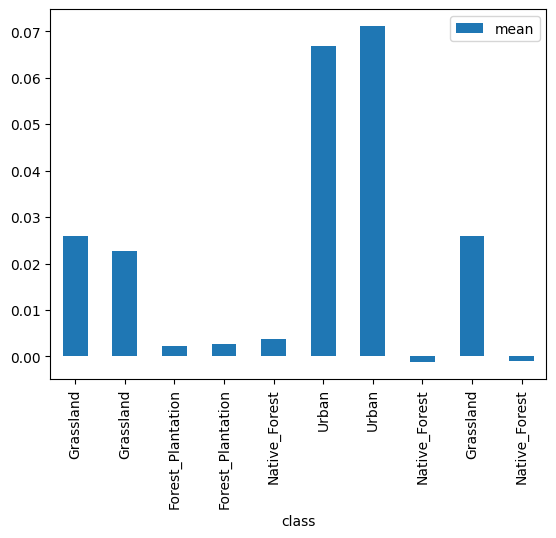

In [143]:
df_avg_reflex.plot(x = 'class', y = 'mean', kind =  'bar')

2. Algunos ejemplos para extraer el valor medio

A: https://pygis.io/docs/f_rs_extraction.html

B: https://gis.stackexchange.com/questions/433246/zonal-statistics-spatial-join-raster-to-polygon-in-python

C: https://www.youtube.com/watch?app=desktop&v=VIr-pejky6E

D: https://www.youtube.com/watch?v=m3uyJOynB54

E: https://gis.stackexchange.com/questions/260304/extract-raster-values-within-shapefile-with-pygeoprocessing-or-gdal

F: https://www.youtube.com/watch?v=QhUcgOOsUy8 # Hatari 

G: https://www.youtube.com/watch?v=LVt8CezezZQ&t=504s # Rasterio for bigginer

https://www.youtube.com/watch?v=ieyODuIjXp4 # Working with geotif in Raster

https://www.youtube.com/watch?v=nCktihu9bWg  # Goespatial Analysis with PyGMT 3D in python

https://www.youtube.com/watch?v=9LDRh5-0Lcw #

In [144]:
#### Tengo que replicar esto para multiples bandas 


In [145]:
# Estudios rasterio 

Composite = rasterio.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\2021\composite_2021_summer.tif')

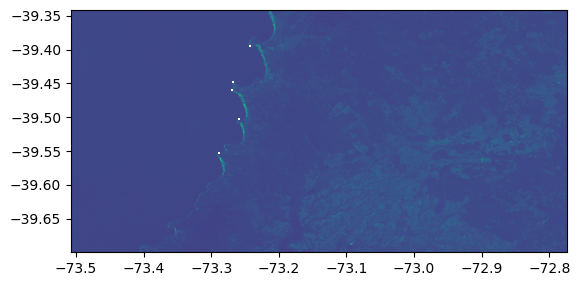

<Axes: >

In [146]:
show(Composite)

In [147]:
composite_data = Composite.read() # Data inside the file Question. How can I select a band

In [148]:
Composite.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 2722,
 'height': 1330,
 'count': 19,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00026949458523585647, 0.0, -73.50734306893222,
        0.0, -0.00026949458523585647, -39.3413585419008)}

In [149]:
composite_data.shape

(19, 1330, 2722)

In [232]:
data_b1 = Composite.read(1)
data_b2 = Composite.read(2)
data_b3 = Composite.read(3)

In [226]:
data_b1

array([[0.0070475 , 0.0055075 , 0.0055075 , ..., 0.00581   , 0.00449   ,
        0.00449   ],
       [0.0066625 , 0.0067175 , 0.0067175 , ..., 0.00273   , 0.002895  ,
        0.002895  ],
       [0.008395  , 0.008395  , 0.00625   , ..., 0.0056175 , 0.004985  ,
        0.004985  ],
       ...,
       [0.00598875, 0.004655  , 0.004655  , ..., 0.01275375, 0.00988   ,
        0.008835  ],
       [0.0054525 , 0.00568625, 0.00568625, ..., 0.014335  , 0.0119425 ,
        0.010815  ],
       [0.00557625, 0.0068    , 0.0068    , ..., 0.012245  , 0.0123    ,
        0.0105675 ]])

In [ ]:
plt.imshow()

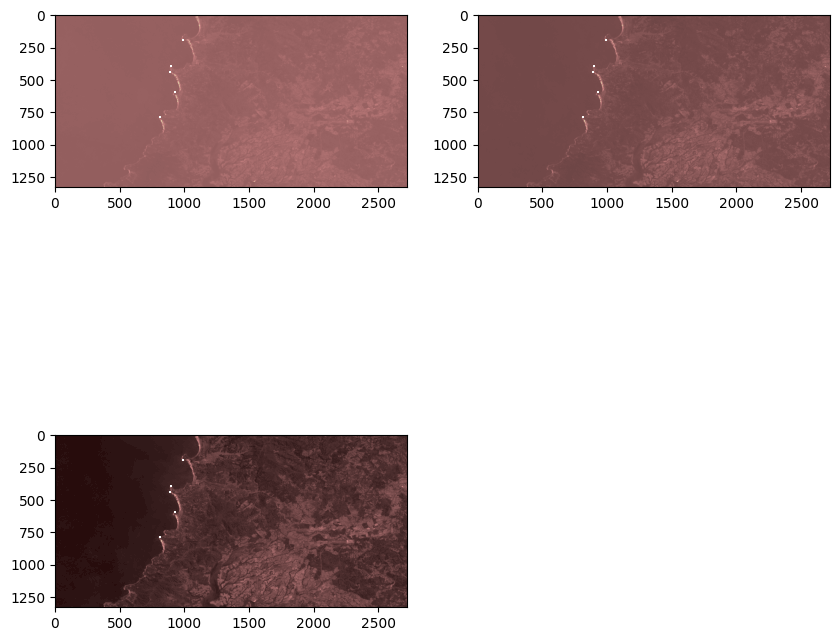

In [238]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(data_b1, cmap = 'pink')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(data_b2, cmap = 'pink')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(data_b3, cmap = 'pink')

In [240]:
clipped_img = composite_data[:, 300:900, 300:900] # subset del objeto numpy array

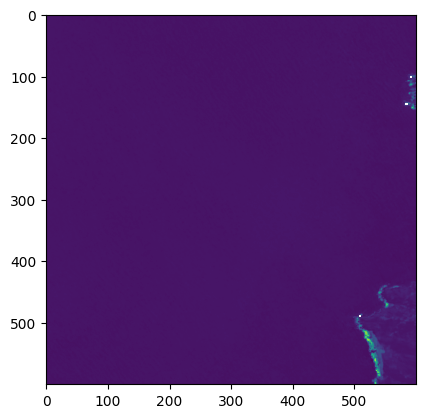

In [245]:
plt.imshow(clipped_img[0,:,:])

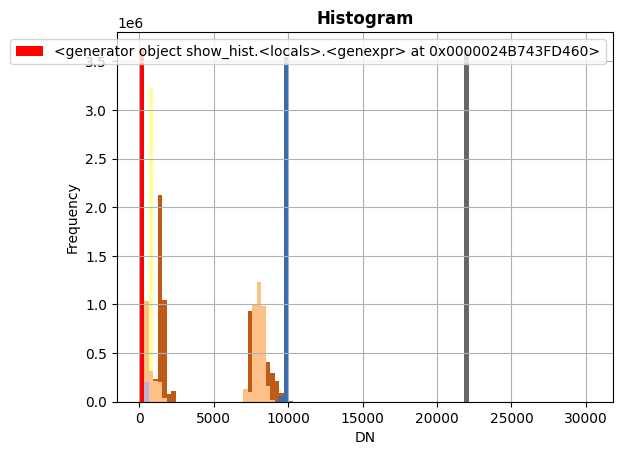

In [150]:
show_hist(Composite, bins = 100, histtype = 'stepfilled', lw = 0.0, stacked = False )

In [221]:
Composite.name

'C:/Users/CRISTIAN/OneDrive - Universidad de Alcala/Classificaciones/2021/composite_2021_summer.tif'

In [159]:
Composite.shape

(1330, 2722)

In [162]:
Composite.height

1330

In [165]:
Composite.descriptions

('SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'SR_QA_AEROSOL',
 'ST_B10',
 'ST_ATRAN',
 'ST_CDIST',
 'ST_DRAD',
 'ST_EMIS',
 'ST_EMSD',
 'ST_QA',
 'ST_TRAD',
 'ST_URAD',
 'QA_PIXEL',
 'QA_RADSAT')

In [166]:
Composite.count

19

In [172]:
Composite.shape

(1330, 2722)

In [171]:
data = Composite.read()
data.dtype

dtype('float64')

In [177]:
Composite.width # Columns

2722

In [180]:
Composite.height # row

1330

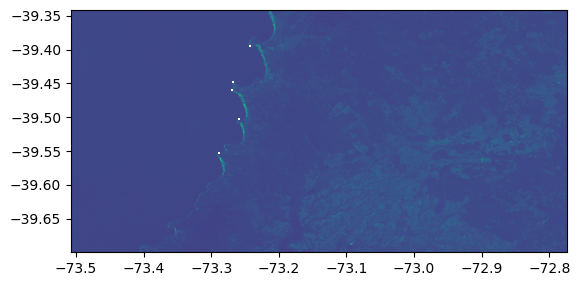

<Axes: >

In [192]:
## How would I only select a few bands

# https://matplotlib.org/stable/gallery/color/colormap_reference.html

show(Composite, cmap = 'viridis')

In [198]:
Composite['SR_B1']

TypeError: 'DatasetReader' object is not subscriptable

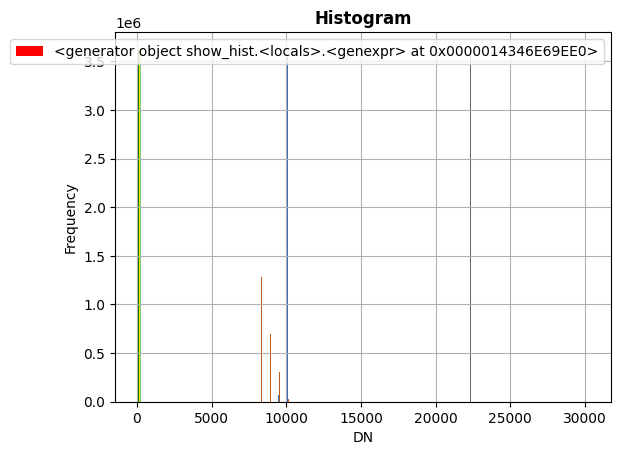

In [194]:
# showhistogram

show_hist(Composite, bins = 50)


## Seleccionar todos los pixesles de un sitio de entrenamiento.

NameError: name 'img_band1' is not defined

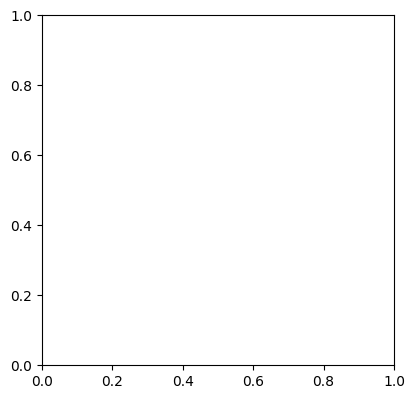

In [ ]:
# Seleccionar todos los pixeles de un sitio de entranamiento. 

In [254]:
import fiona

In [ ]:
training_sites = gpd.read_file(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg')

In [255]:
shapefile_path = r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg'

In [256]:
tiff_file = r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg'

'C:\\Users\\CRISTIAN\\OneDrive - Universidad de Alcala\\Classificaciones\\trabajo sitios de entrenamiento\\2021\\sitios_entrenamient_geo.gpkg'

In [258]:
tiff_file = r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\2021\SR_B1_2021.tif'

In [268]:
with fiona.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg',  layer = 'sitios_entrenamient_2021') as layer:
    for feature in layer:
        shapes = ([feature['geometry']])

In [270]:
from rasterio import mask

In [271]:
with rasterio.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\2021\SR_B1_2021.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop = True)
    out_meta = src.meta

In [272]:
out_meta.update({
    "driver": 'Gtiff',
    "height": out_image.shape[1],
    'width': out_image.shape[2],
    'transform': out_transform
    
})

In [281]:
type(out_image)

numpy.ndarray

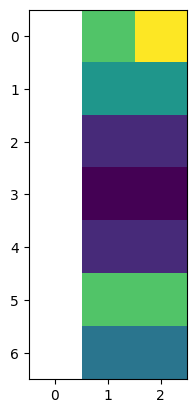

<Axes: >

In [282]:
show(out_image)

# Intento numero 3

In [418]:
gpkg_path = r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg'
gdf = gpd.read_file(gpkg_path)



In [419]:
from rasterio.features import geometry_mask
import geowombat as gw

ModuleNotFoundError: No module named 'geowombat'

In [420]:
# Open and read the raster file
raster_path = r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\2021\SR_B1_2021.tif'
with rasterio.open(raster_path) as src:
    # Rasterize the polygons to the raster grid
    mask = geometry_mask(gdf.geometry, src.bounds, src.shape, invert=True)
    # Convert the mask to a GeoDataFrame
    mask_gdf = gpd.GeoDataFrame({'geometry': gdf.geometry[mask]})

    # Extract raster values for each polygon using geowombat
    extracted_values = gw.extract(src, mask_gdf, bands='all')

# Display the extracted values
print(extracted_values)

ValueError: Invalid out_shape, must be 2D

## Lo que tengo que hacer primero es pasar el raasster a puntos. 
## Luego extraer el valor para cada punto.


In [408]:
import folium

In [407]:
map2 = folium.Map(location=[-39.4099, -73.165], tiles='CartoDB positron', zoom_start=11)

In [406]:
map2

In [472]:
training_sites_points = gpd.read_file(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg', layer = 'sitios_entranamientos_puntos' )

In [473]:
training_sites_points

,categoria,descrpcion,id_clase,geometry
0,Plantacion,NaN,1,POINT (-73.11308 -39.42804)
1,Plantacion,NaN,1,POINT (-73.11296 -39.42821)
2,Plantacion,NaN,1,POINT (-73.11274 -39.42821)
3,Plantacion,NaN,1,POINT (-73.11282 -39.42783)
4,Plantacion,NaN,1,POINT (-73.11299 -39.42774)
...,...,...,...,...
119,Bosque Nativo,NaN,2,POINT (-73.07546 -39.37087)
120,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37035)
121,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37063)
122,Bosque Nativo,NaN,2,POINT (-73.07519 -39.37086)


In [474]:
# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in training_sites_points.geometry]

In [475]:
# Falta aqui como mostrar popup
for coordinates in geo_df_list:
    folium.Marker(location = coordinates).add_to(map2)
    

In [416]:
map2

In [476]:
# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type of volcano, Strato being the most common
    if training_sites_points.categoria[i] == 1:
        type_color = "green"
    elif training_sites_points.categoria[i] == 2:
        type_color = "blue"
    elif training_sites_points.categoria[i] == 3:
        type_color = "orange"
    elif training_sites_points.categoria[i] == 4:
        type_color = "pink"
    else:
        type_color = "purple"

    # Place the markers with the popup labels and data
    map2.add_child(
        folium.Marker(
            location=coordinates
        )
    )
i = i + 1

In [477]:
map2

In [478]:
training_sites_points

,categoria,descrpcion,id_clase,geometry
0,Plantacion,NaN,1,POINT (-73.11308 -39.42804)
1,Plantacion,NaN,1,POINT (-73.11296 -39.42821)
2,Plantacion,NaN,1,POINT (-73.11274 -39.42821)
3,Plantacion,NaN,1,POINT (-73.11282 -39.42783)
4,Plantacion,NaN,1,POINT (-73.11299 -39.42774)
...,...,...,...,...
119,Bosque Nativo,NaN,2,POINT (-73.07546 -39.37087)
120,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37035)
121,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37063)
122,Bosque Nativo,NaN,2,POINT (-73.07519 -39.37086)


In [479]:
Composite = rasterio.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\2021\composite_2021_summer.tif')

In [480]:
# Extraer las coordenadas de los puntos
coords = [(x,y) for x, y in zip(training_sites_points.geometry.x, training_sites_points.geometry.y)]

In [454]:
banda_deseada = 1

In [483]:
training_sites_points['B1'] = [x[0] for x in Composite.sample(coords, indexes=1)]
training_sites_points['B2'] = [x[0] for x in Composite.sample(coords, indexes=2)]
training_sites_points['B3'] = [x[0] for x in Composite.sample(coords, indexes=3)]
training_sites_points['B4'] = [x[0] for x in Composite.sample(coords, indexes=4)]
training_sites_points['B5'] = [x[0] for x in Composite.sample(coords, indexes=5)]
training_sites_points['B6'] = [x[0] for x in Composite.sample(coords, indexes=6)]
training_sites_points['B7'] = [x[0] for x in Composite.sample(coords, indexes=7)]


In [481]:
training_sites_points

,categoria,descrpcion,id_clase,geometry
0,Plantacion,NaN,1,POINT (-73.11308 -39.42804)
1,Plantacion,NaN,1,POINT (-73.11296 -39.42821)
2,Plantacion,NaN,1,POINT (-73.11274 -39.42821)
3,Plantacion,NaN,1,POINT (-73.11282 -39.42783)
4,Plantacion,NaN,1,POINT (-73.11299 -39.42774)
...,...,...,...,...
119,Bosque Nativo,NaN,2,POINT (-73.07546 -39.37087)
120,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37035)
121,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37063)
122,Bosque Nativo,NaN,2,POINT (-73.07519 -39.37086)


In [464]:
Composite.count

19

In [484]:
training_sites_points

,categoria,descrpcion,id_clase,geometry,B1,B2,B3,B4,B5,B6,B7
0,Plantacion,NaN,1,POINT (-73.11308 -39.42804),0.002125,0.004903,0.012630,0.007047,0.196165,0.039470,0.014692
1,Plantacion,NaN,1,POINT (-73.11296 -39.42821),0.003142,0.005123,0.012795,0.006800,0.217505,0.042550,0.015105
2,Plantacion,NaN,1,POINT (-73.11274 -39.42821),0.003142,0.005123,0.012795,0.006800,0.217505,0.042550,0.015105
3,Plantacion,NaN,1,POINT (-73.11282 -39.42783),0.002785,0.004655,0.012822,0.007212,0.198447,0.041725,0.015352
4,Plantacion,NaN,1,POINT (-73.11299 -39.42774),0.002785,0.004655,0.012822,0.007212,0.198447,0.041725,0.015352
...,...,...,...,...,...,...,...,...,...,...,...
119,Bosque Nativo,NaN,2,POINT (-73.07546 -39.37087),-0.001175,0.003830,0.033255,0.014417,0.308021,0.055420,0.018116
120,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37035),-0.002206,0.002634,0.026806,0.012382,0.266496,0.055557,0.020454
121,Bosque Nativo,NaN,2,POINT (-73.07520 -39.37063),-0.001299,0.003459,0.030670,0.013592,0.288675,0.055502,0.018721
122,Bosque Nativo,NaN,2,POINT (-73.07519 -39.37086),-0.001175,0.003830,0.033255,0.014417,0.308021,0.055420,0.018116


In [ ]:
training_sites_points.to_csv('training_sites_points_raster_value.csv', encoding= 'ISO-8859-1')

In [465]:
Composite.descriptions

('SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'SR_QA_AEROSOL',
 'ST_B10',
 'ST_ATRAN',
 'ST_CDIST',
 'ST_DRAD',
 'ST_EMIS',
 'ST_EMSD',
 'ST_QA',
 'ST_TRAD',
 'ST_URAD',
 'QA_PIXEL',
 'QA_RADSAT')

Como extraer el valor de cada banda a partir de un conjunto de puntos